# Training a Siamese model with a triplet loss function on MNIST dataset using PyTorch

In this notebook, you can find the example code for this repo (https://github.com/ziadloo/Siamese-model-in-Pytorch) that trains a Siamese model using a triplet loss function over the MNIST dataset. The same technique could be used to train a Siamese model on any dataset.

Let's start by loading the needed libraries.

In [1]:
import torch
from torch import nn
import torchvision
import random
import copy
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, RandomAffine

import sys
import os

# Add the path of the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Now you can perform relative imports
from Siamese import SiameseDataLoader, SiameseSampleGenerator, SiameseDataset, SiameseModel, triplet_loss

## Loading the dataset

First, we need to load the dataset. PyTorch has helper method to make it easy.

In [2]:
training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Once the data is loaded, we should convert it into a format that is suitable for the Siamese model.

A Siamese model consumes the data in a very specifice way. Each mini-batch should be composed of two tensors. The shape of these two tensors should be the same and they'll have the same shape as of your dataset plus a batch dimension. It's just that each sample in the batch should have the same class as the sample in the other batch in the same position. Here's what it looks like:

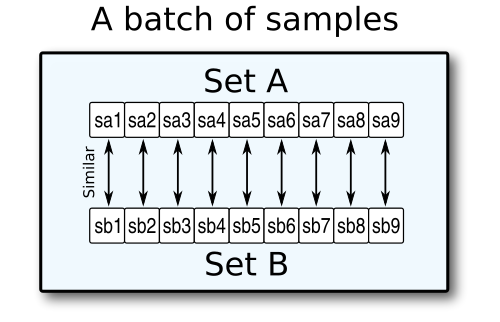

One more thing is that `sa1`'s class is different from the rest of the samples in the batch. The formal mathematical way of saying the same thing is:

\begin{equation}
  \forall i, j \in B, \begin{cases}
    \text{class(sa[i]) $=$ class(sb[j])}, \:\: & \text{if $i = j$}\\
    \text{class(sa[i]) $\neq$ class(sb[j])}, \:\: & \text{if $i \neq j$} &
  \end{cases}
\end{equation}

In this way, our `batch_size` cannot be larger than the different number of classes that we have. So here, `batch_size` could be as large as 10.

Using the following code, we'll make this happen.

In [3]:
train_samples = [[] for i in range(10)]
for X, y in training_mnist:
    train_samples[y].append(X)

test_samples = [[] for i in range(10)]
test_reverse_index = [{} for i in range(10)]
for i, (X, y) in enumerate(test_mnist):
    test_samples[y].append(X)
    test_reverse_index[y][len(test_samples[y])-1] = i

class MnistGenerator(SiameseSampleGenerator):
    def __init__(self, ds, transform=None):
        self.samples = ds
        random.shuffle(self.samples)
        self.counter = 0
        self.transform = transform

    def shuffle(self):
        random.shuffle(self.samples)

    def __call__(self):
        curr = self.counter
        self.counter = (self.counter + 1) % len(self.samples)
        if self.transform is not None:
            return self.transform(self.samples[curr])
        else:
            return self.samples[curr]

Having grouped the samples by their label, the `MnistGenerator` class will return one sample per each group when called. Then, the `SiameseDataset` class will use these generators to compose batches of data match the structure explained above.

In [4]:
batch_size = 10
class_count = 10

assert batch_size <= class_count

# Train dataloader
training_generators = [MnistGenerator(train_samples[i]) for i in range(class_count)]
training_data = SiameseDataset(len(train_samples[0]), training_generators)
train_dataloader = SiameseDataLoader(training_data, batch_size=batch_size, class_count=class_count)

# Test dataloader
test_generators = [MnistGenerator(test_samples[i]) for i in range(class_count)]
test_data = SiameseDataset(len(test_samples[0]), test_generators)
test_dataloader = SiameseDataLoader(test_data, batch_size=batch_size, class_count=class_count)

## Tower design

Next, we'll define our tower model. The design of the tower model is irrelevant to the Siamese model. All the requirements that you need to satisfy are as follows:

1. Make sure the input shape matches the dataset samples. To be clear, the input shape of the tower should match `sa1` in the exampled example above and *not* `(sa1, sb1)`.
2. The output shape of the tower should be a one dimensional vector of your desired length. The number of elements in the vector represents the latent space that you are encoding your input into.
3. The last requirement is very important. The output vector of the tower should be of magnitute of `1`.

As long as the tower model satisfies the mentioned conditions above, the rest its design is arbitrary. In case of our example here, since we are dealing with images, CNN is preferred way of choice.

In [5]:
import torch
from torch import nn


class MnistCnn(nn.Module):
    def __init__(self, latent_size):
        super(MnistCnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, latent_size * 3)
        self.fc3 = nn.Linear(latent_size * 3, latent_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x / torch.sqrt(torch.sum(x * x, dim=-1, keepdim=True))

Next, we'll instantiate an object from the tower and wrap it in a Siamese model.

In [6]:
# Tower model
tower = MnistCnn(128)
# Siamese model
siamese = SiameseModel(tower)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


siamese = siamese.to(device)
print(siamese)

Using cuda device
SiameseModel(
  (tower): MnistCnn(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=1568, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=384, bias=True)
    (fc3): Linear(in_features=384, out_features=128, bias=True)
  )
)


## Training the model

The training step of a Siamese model is exactly the same as any ordinary model. The only difference is that the dataloader as well as the model deal with the data in pairs.

In [7]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    total_counter = 0
    for batch, (s1, s2) in enumerate(dataloader):
        s1, s2 = s1.to(device), s2.to(device)

        # Compute prediction error
        v1, v2 = model((s1, s2))
        loss = loss_fn(v1, v2)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        total_counter += 1

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(s1)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    total_loss += loss.item()
    total_counter += 1
    total_loss /= total_counter

    return total_loss


def test(dataloader, model, loss_fn, device):
    def accuracy(v1, v2):
        scores = torch.mm(v1, v2.t())
        m = torch.argmax(scores, dim=-1).to(v1.get_device())
        i = torch.arange(len(m)).to(v1.get_device())
        mark_list = torch.where(i == m, torch.tensor(1).to(v1.get_device()), torch.tensor(0).to(v1.get_device()))
        mark = torch.sum(mark_list).to(v1.get_device())
        return mark / len(mark_list)

    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    test_acc = 0
    num_batches = 0
    with torch.no_grad():
        for s1, s2 in dataloader:
            s1, s2 = s1.to(device), s2.to(device)
            v1, v2 = model((s1, s2))
            test_loss += loss_fn(v1, v2)
            test_acc += accuracy(v1, v2)
            num_batches += 1
    test_loss /= num_batches
    test_acc /= num_batches

    return test_loss, test_acc

The only thing left is to train the model.

In [8]:
optimizer = torch.optim.SGD(siamese.parameters(), lr=1e-3, momentum=0.7)

best_acc = 0
epochs = 10
for t in range(epochs):
    print("-------------------------------")
    print(f"Epoch {t+1}/{epochs}")
    print("-------------------------------")
    train_loss = train(train_dataloader, siamese, triplet_loss, optimizer, device)
    test_loss, test_acc = test(test_dataloader, siamese, triplet_loss, device)

    print(f"\nTrain Loss: {train_loss:>7f}")
    print(f"Test Avg Loss: {test_loss:>8f}")
    print(f"Test Avg Acc: {test_acc:>8f} \n")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_tower = MnistCnn(128)
        best_tower.load_state_dict(copy.deepcopy(tower.state_dict()))

print("Done!")

-------------------------------
Epoch 1/10
-------------------------------

Train Loss: 1.414706
Test Avg Loss: 0.852309
Test Avg Acc: 0.870408 

-------------------------------
Epoch 2/10
-------------------------------

Train Loss: 0.743327
Test Avg Loss: 0.563912
Test Avg Acc: 0.943878 

-------------------------------
Epoch 3/10
-------------------------------

Train Loss: 0.513141
Test Avg Loss: 0.414955
Test Avg Acc: 0.956123 

-------------------------------
Epoch 4/10
-------------------------------

Train Loss: 0.372003
Test Avg Loss: 0.285421
Test Avg Acc: 0.960204 

-------------------------------
Epoch 5/10
-------------------------------

Train Loss: 0.275440
Test Avg Loss: 0.211434
Test Avg Acc: 0.969388 

-------------------------------
Epoch 6/10
-------------------------------

Train Loss: 0.231716
Test Avg Loss: 0.230751
Test Avg Acc: 0.966327 

-------------------------------
Epoch 7/10
-------------------------------

Train Loss: 0.208671
Test Avg Loss: 0.180134
Tes

## Analyzing the results

With the training done, let's see how the model is doing. Even though we do have the accuracy as part of the training process, but there much more we can dig.

First, let's start by repackaging the test samples into something more suitable for our analysis.

In [9]:
test_tensor = torch.cat([torch.cat([torch.unsqueeze(l, 0) for l in s]) for s in test_samples])

print(f"test_tensor.shape: {test_tensor.shape}")

test_tensor.shape: torch.Size([10000, 1, 28, 28])


Now we can use our trained model and generate the embeddings for each of the samples. Once we have the embeddings, a simple matrix multiplication will give us the cosine distance between any two samples.

In [10]:
tower.eval()

with torch.no_grad():
    test_tensor.to(device)
    embeddings = best_tower(test_tensor)
    print(f"embeddings.shape: {embeddings.shape}")

similarity = torch.mm(embeddings, embeddings.t())
print(f"similarity.shape: {similarity.shape}")

embeddings.shape: torch.Size([10000, 128])
similarity.shape: torch.Size([10000, 10000])


Now let's visualize the similarity matrix. For the sake of better visibility, the Y axis in the following charts are in logarithmic scaled.

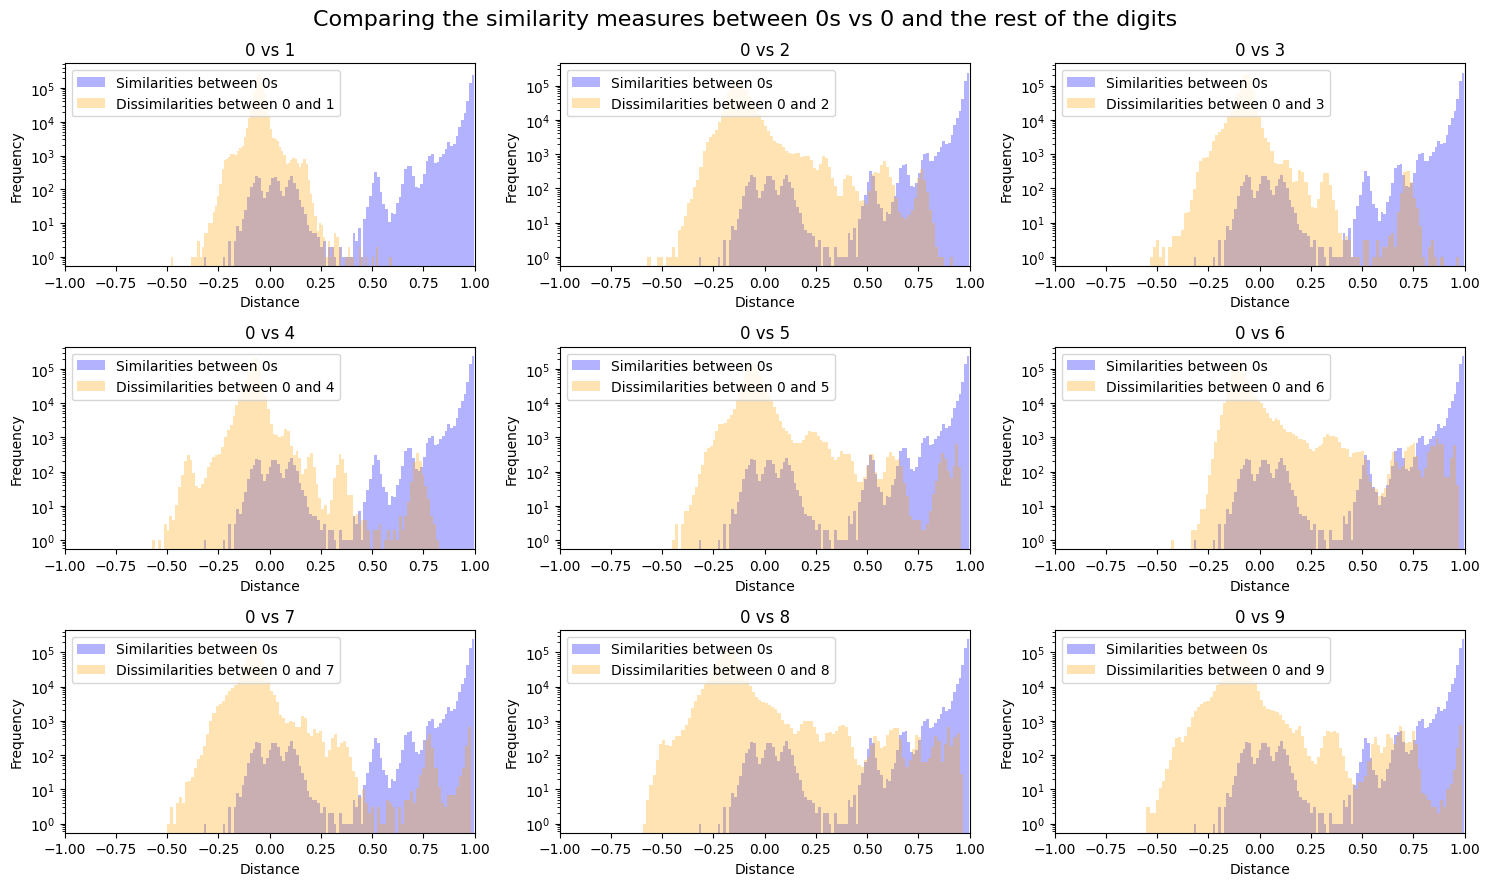

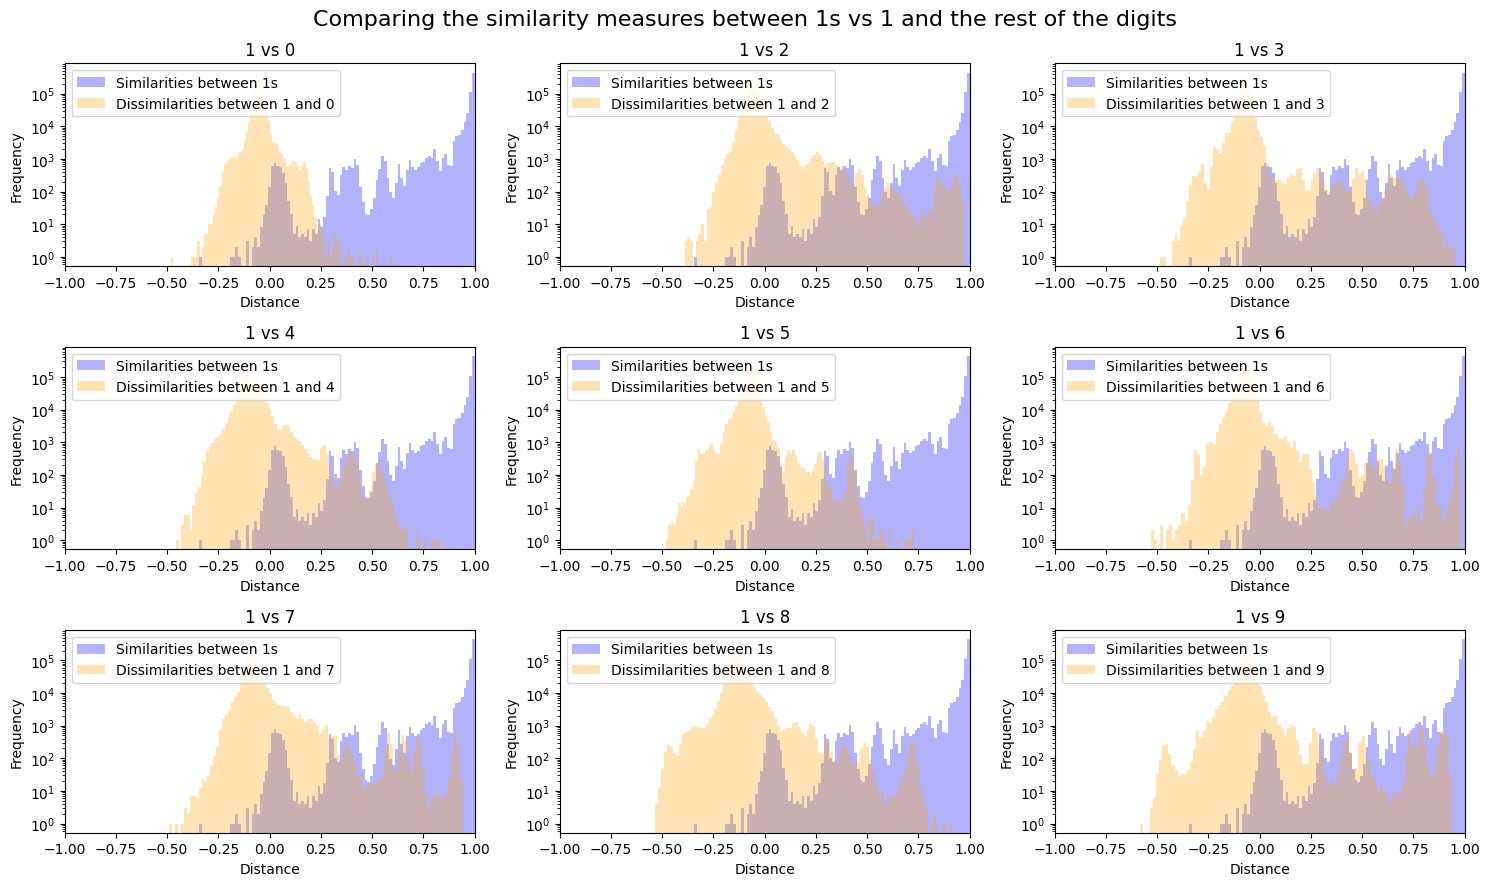

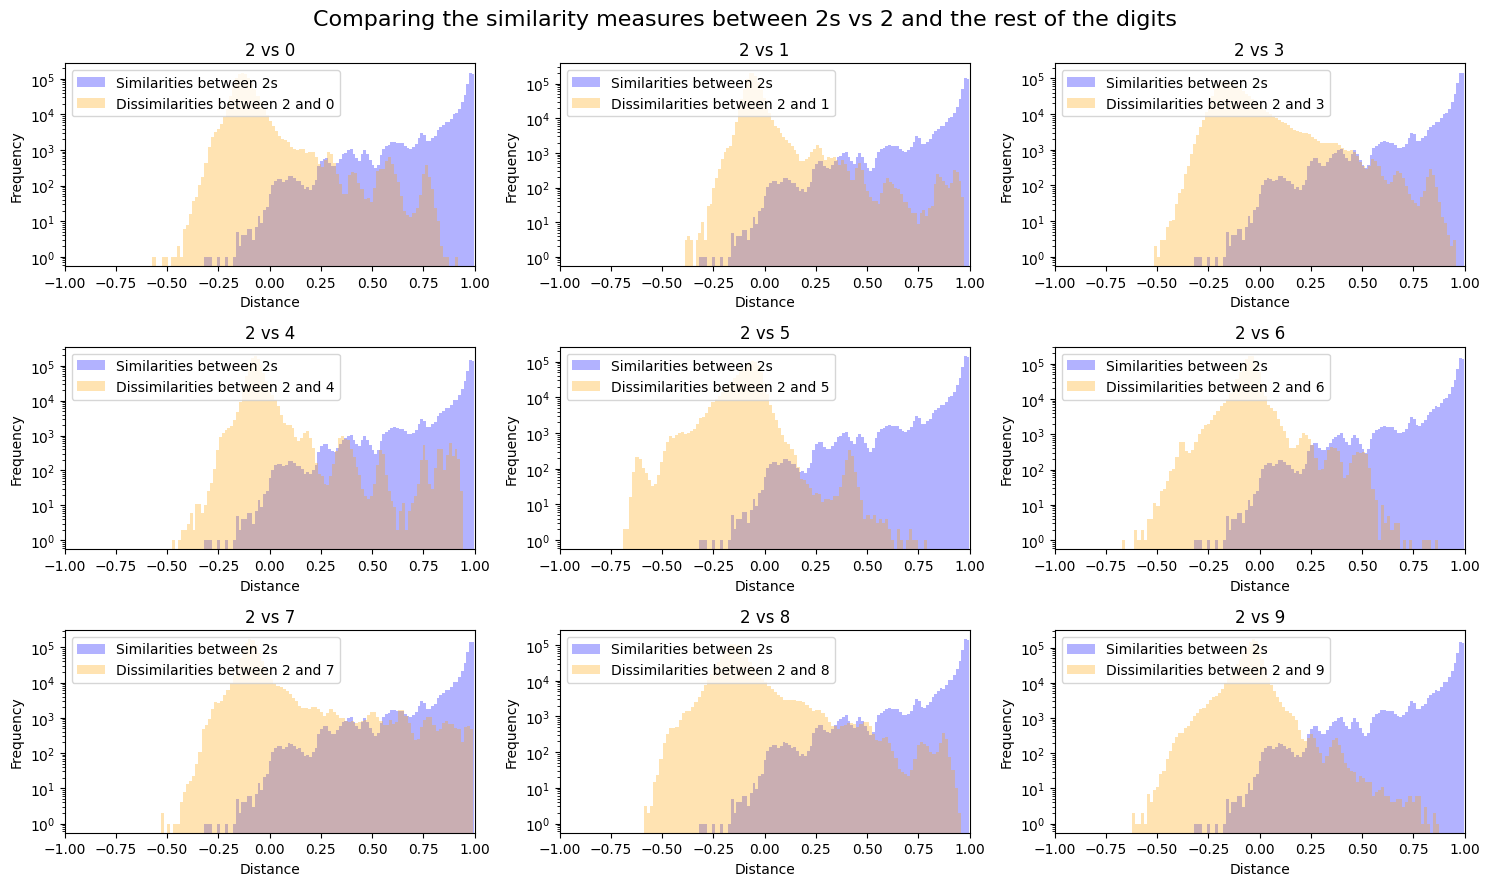

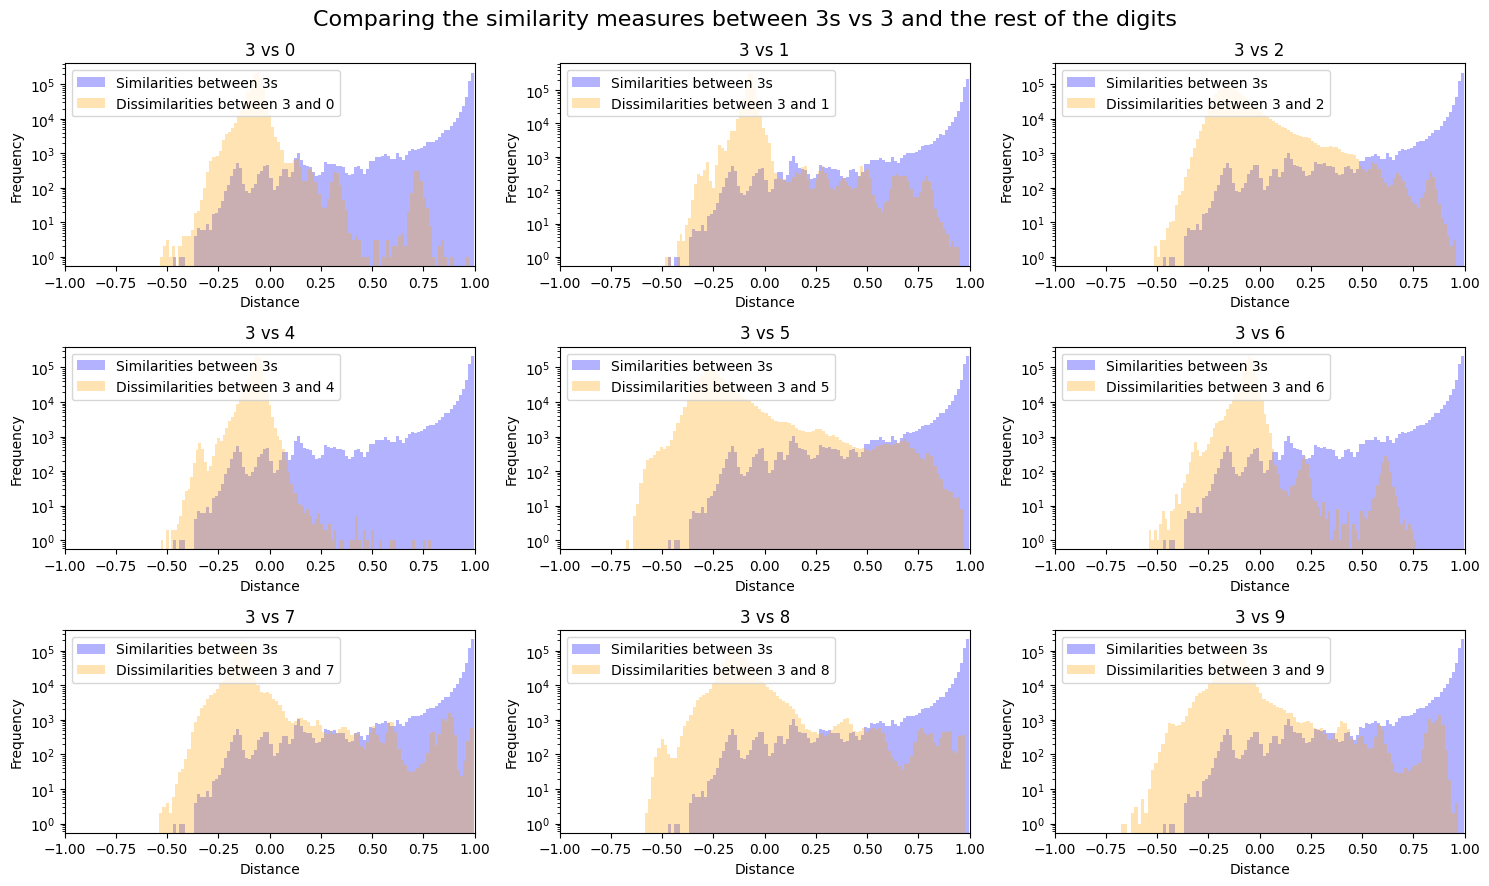

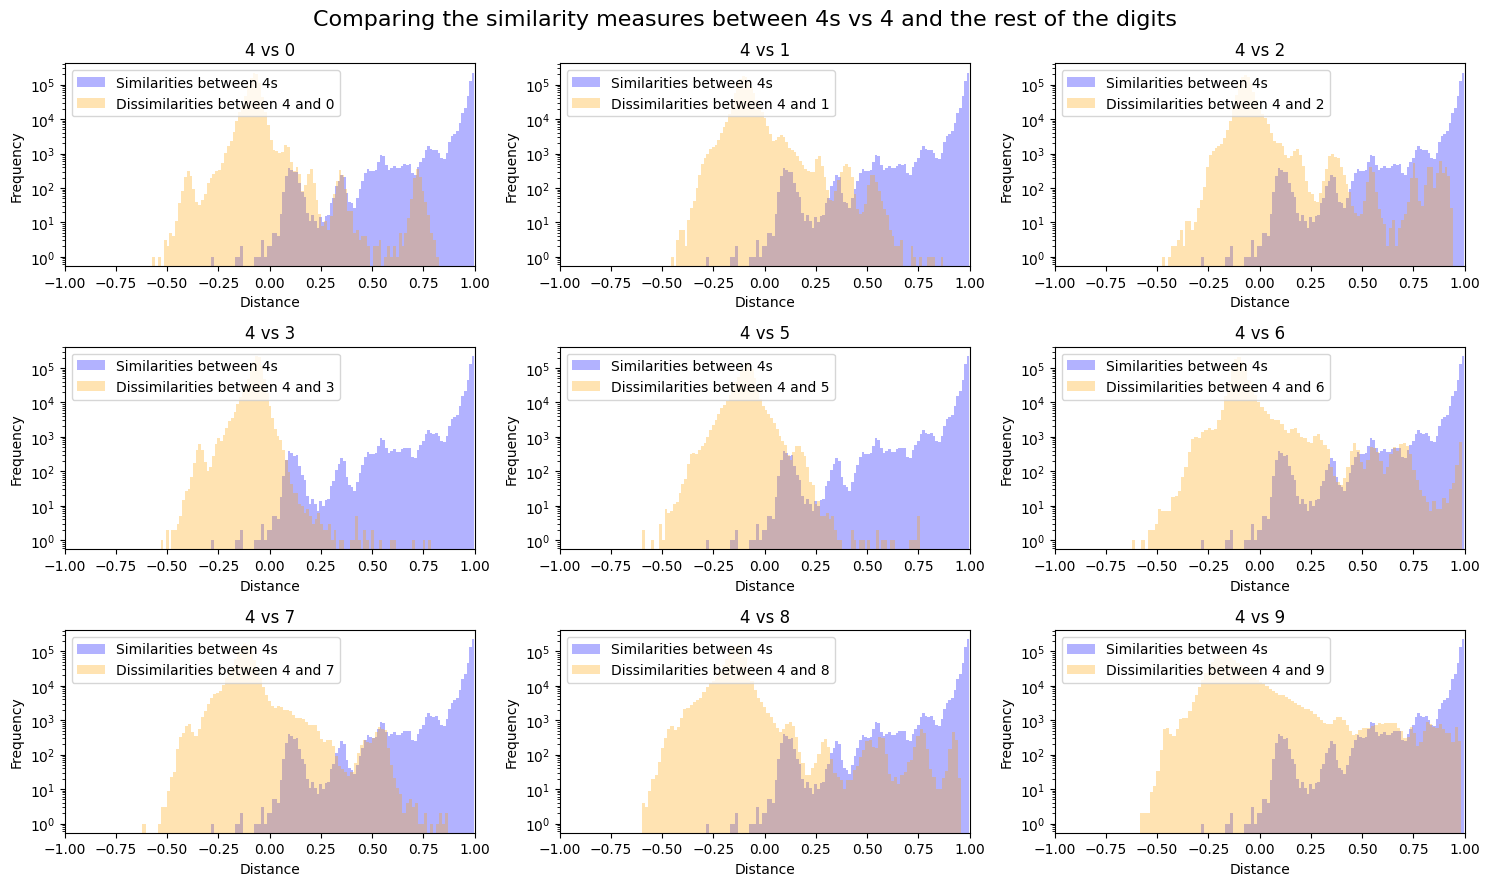

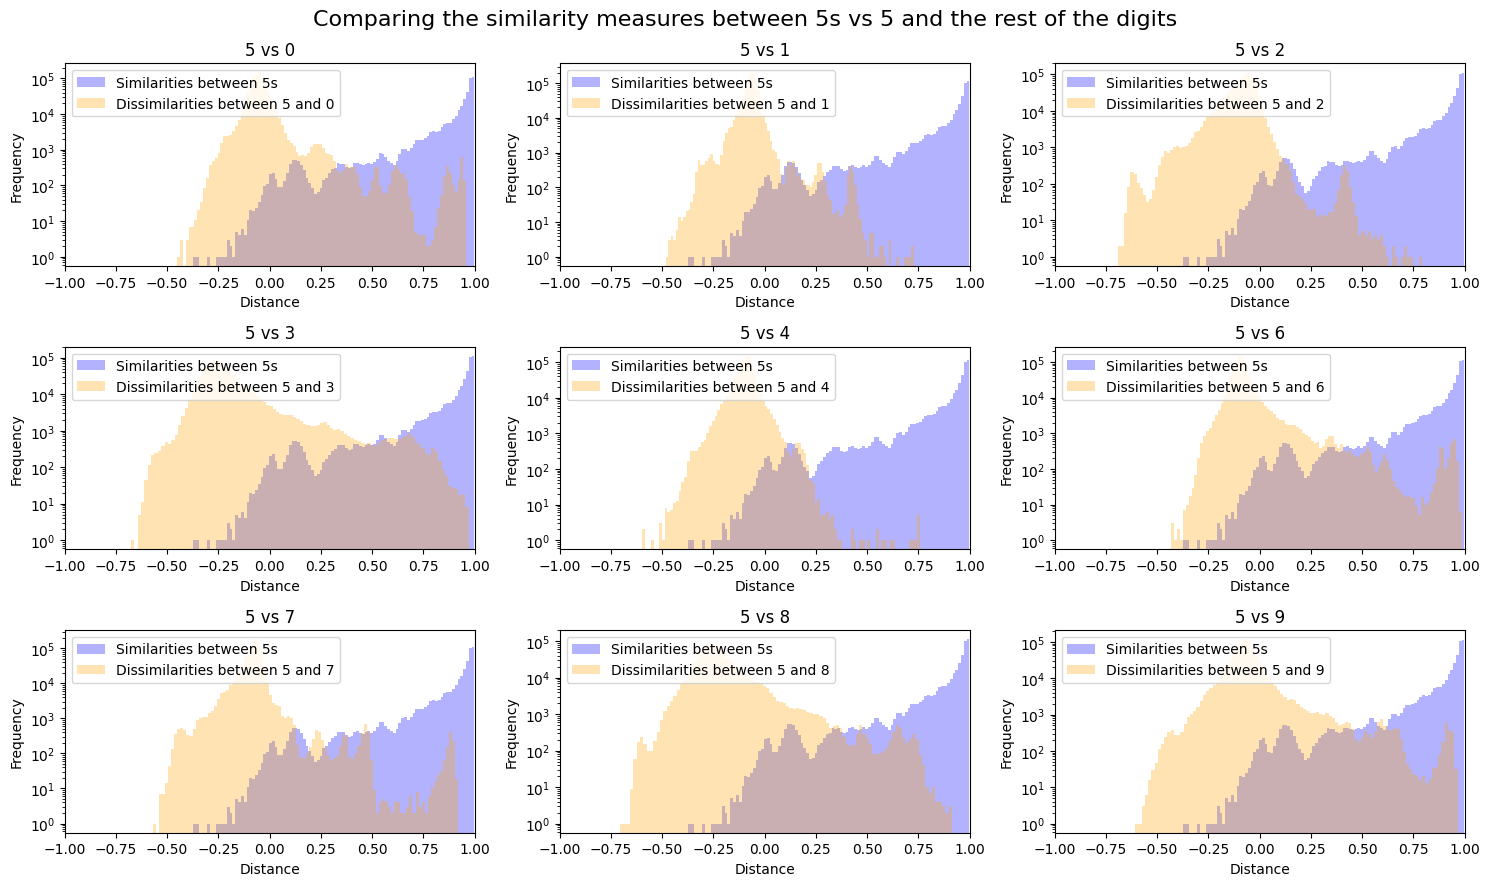

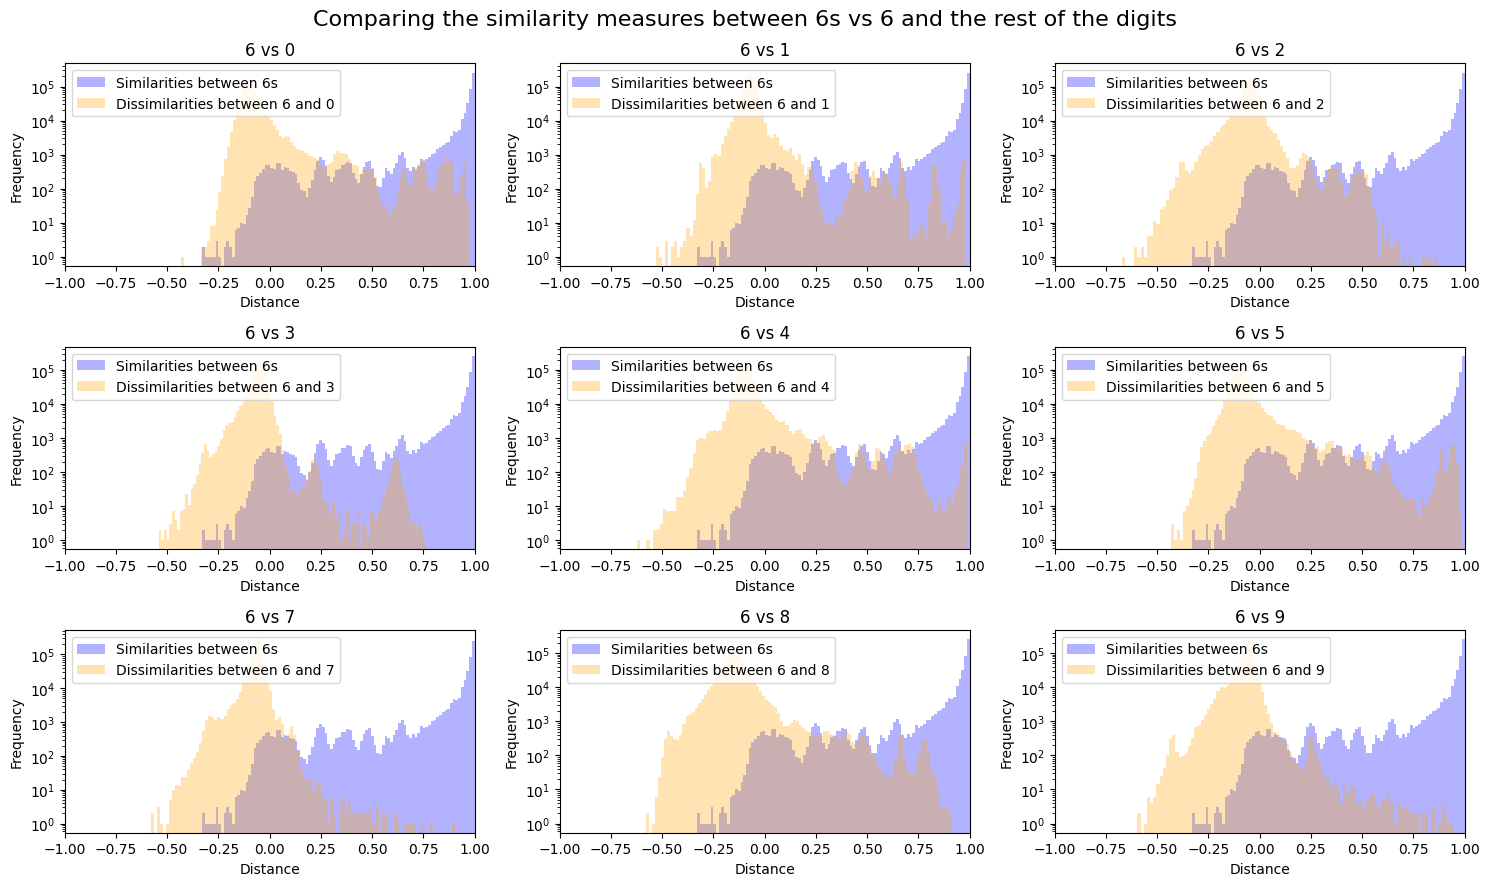

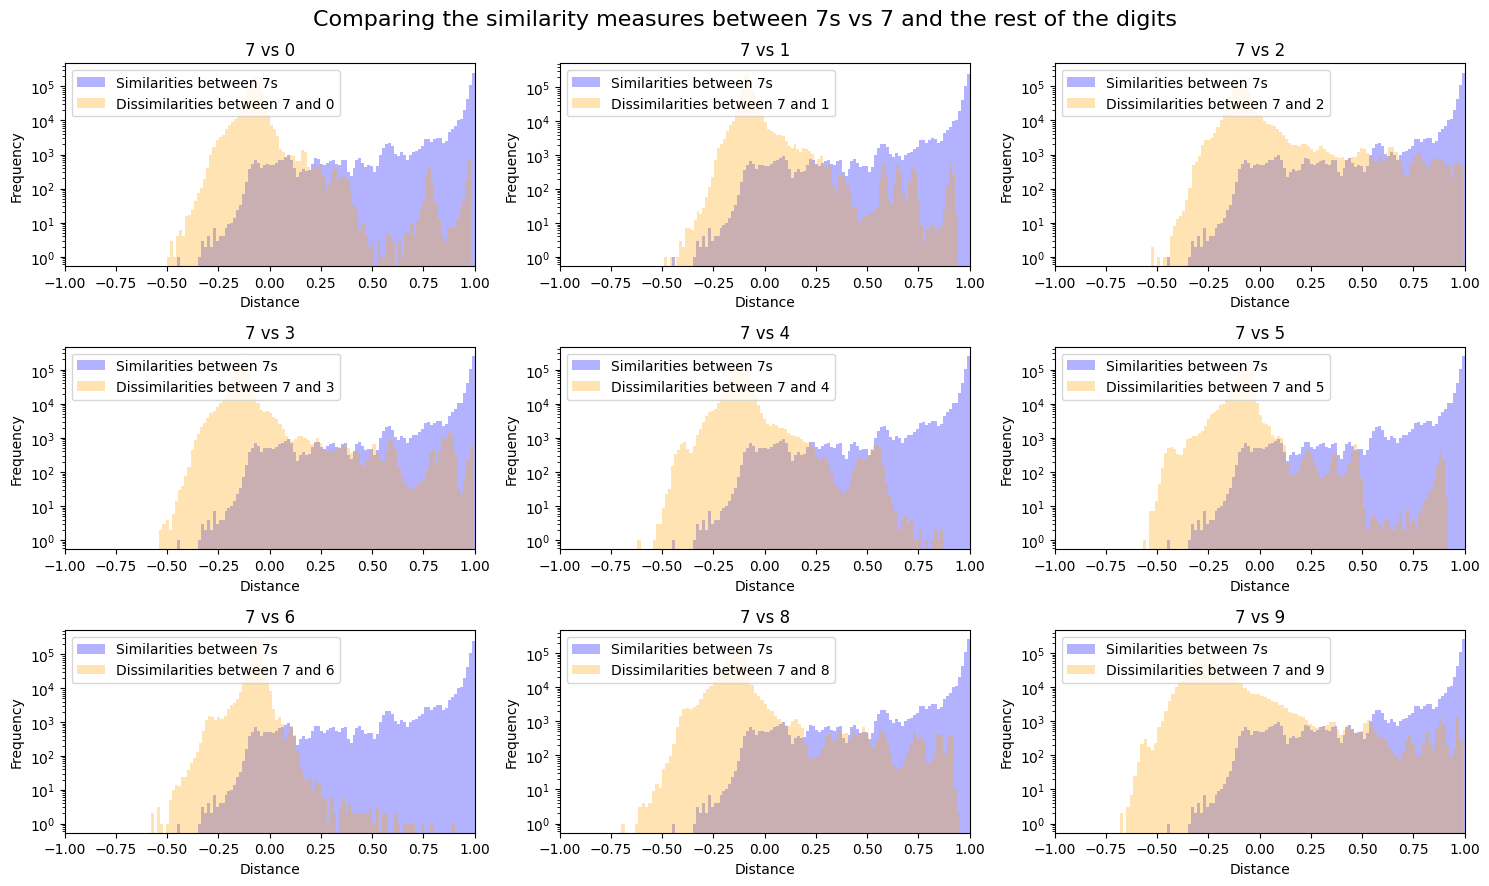

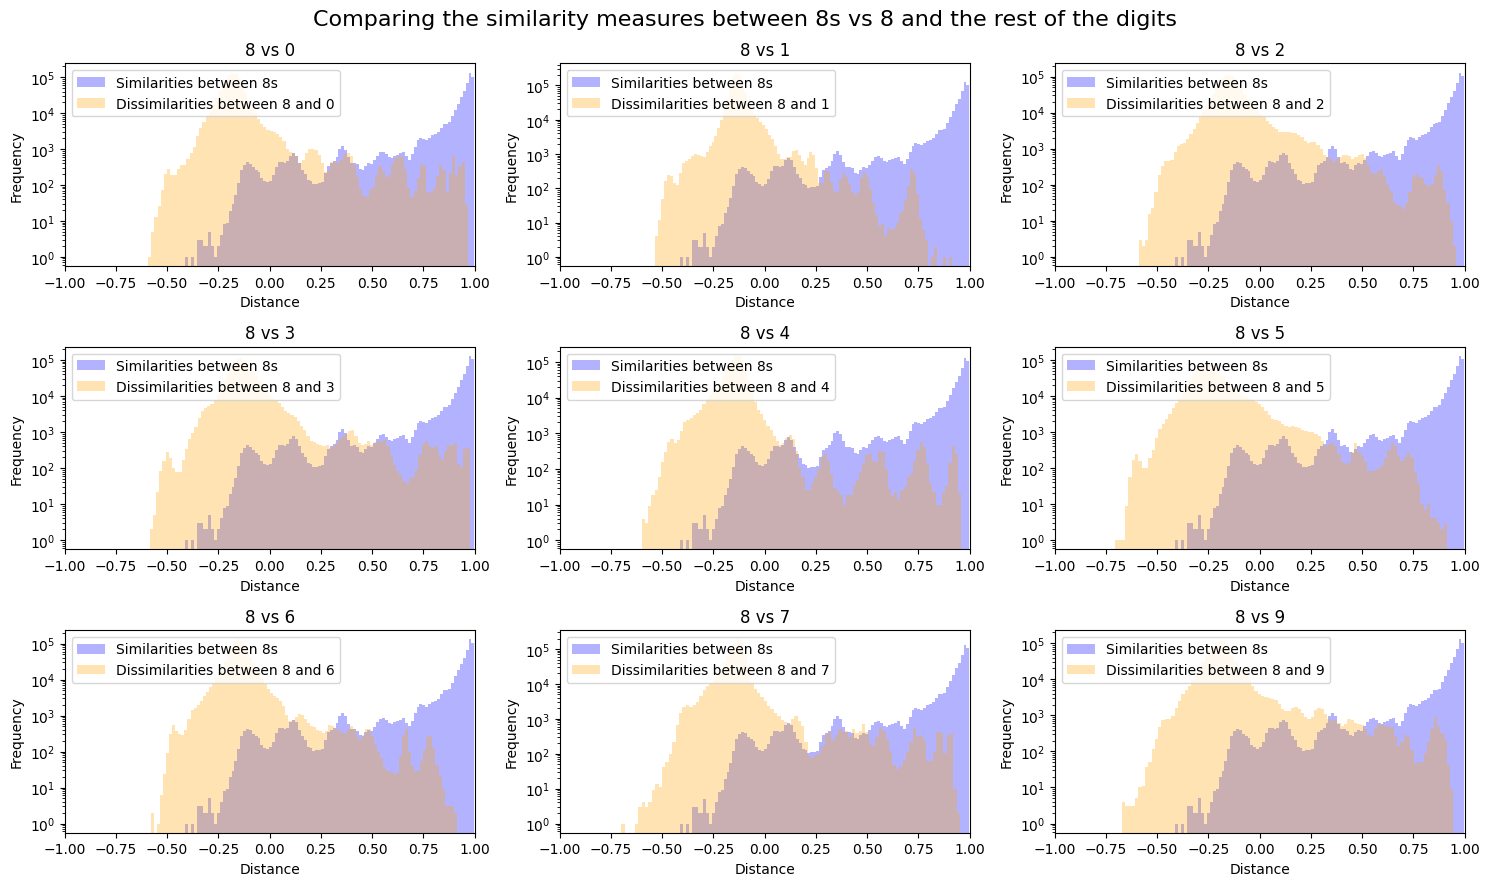

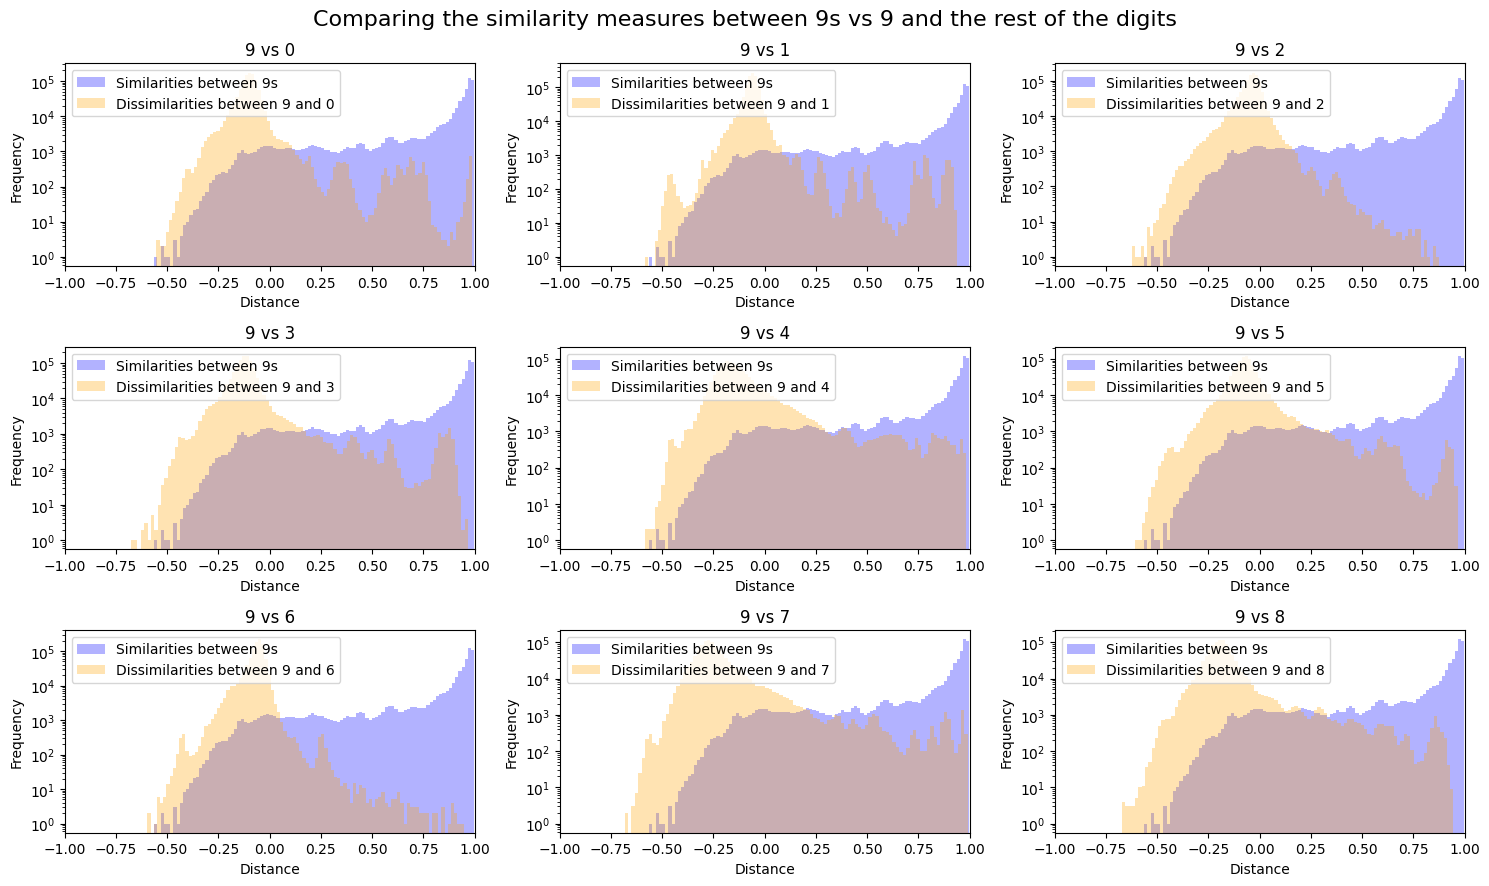

In [11]:
import matplotlib.pyplot as plt


def plot_histograms_in_grid(sim, dis_list, sim_index, dis_index):
    fig, axes = plt.subplots(3, 3, figsize=(15, 3*3))  # Create a grid of subplots
    
    for i, dis_key in enumerate(dis_list):
        row = i // 3
        col = i % 3
        
        ax = axes[row, col]
        ax.set_xlim(-1, 1)
        
        # Plot histograms for the first pair
        ax.hist(sim, bins=100, alpha=0.3, color='blue', label=f'Similarities between {sim_index}s')
        ax.hist(dis[dis_key], bins=100, alpha=0.3, color='orange', label=f'Dissimilarities between {sim_index} and {dis_key}')
        
        ax.set_title(f'{sim_index} vs {dis_key}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        
        ax.legend(loc='upper left')

    fig.suptitle(f"Comparing the similarity measures between {sim_index}s vs {sim_index} and the rest of the digits", fontsize=16)
    plt.tight_layout()
    plt.show()
    print()


for d1 in range(10):
    dis = {}
    for d2 in range(10):
        row_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
        row_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])
        
        col_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
        col_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])
        
        if d1 == d2:
            sim = similarity[row_start:row_end, col_start:col_end]
            n = sim.shape[0]
            indices = torch.tril_indices(n, n, offset=-1)  # Get indices of lower triangle elements
            sim = sim[indices[0], indices[1]]       # Index into tensor using the indices
        else:
            dis[d2] = similarity[row_start:row_end, col_start:col_end].reshape((-1,)).tolist()

    plot_histograms_in_grid(sim, dis, d1, d2)

## Digging deeper

Well, that was a lot of charts. To understand the behaviour of the model, let's look into some of the cases that the model had a hard time with. Namely, it seems like the model had hard time in "9 vs 4". In that figure, there is a considerable overlap between the scores of the similar and dissimilar cases.

In order to understand the difficulty of the problem, let's find some of the samples. For instance, let's find samples of the digit `9`s which are very similar to `4`s, samples of `4`s which are very much like `9`s and `9`s which are not similar to each other.

In [12]:
import torch
import torchvision
import matplotlib.pyplot as plt

def display_mnist_pairs(test_dataset, pair_indices_list, test_reverse_index, label_1, label_2):
    # Display pairs of images corresponding to the given pairs of indices
    num_pairs = len(pair_indices_list)
    fig, axes = plt.subplots(num_pairs, 2, figsize=(4, 3 * num_pairs))

    for i, (idx1, idx2, sim) in enumerate(pair_indices_list):
        image1, label1 = test_dataset[test_reverse_index[label_1][idx1]]
        image2, label2 = test_dataset[test_reverse_index[label_2][idx2]]

        axes[i, 0].imshow(image1.squeeze().numpy(), cmap='gray')
        axes[i, 0].set_title(f"Similarity: {sim}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image2.squeeze().numpy(), cmap='gray')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


def find_indices_of_top_k(tensor_2d, k, largest=True):
    values, indices = tensor_2d.reshape(-1).topk(k, largest=largest)
    
    # Convert indices to row and column indices
    row_indices = indices // tensor_2d.size(1)
    col_indices = indices % tensor_2d.size(1)

    return [(row_indices[i].item(), col_indices[i].item(), values[i].item()) for i in range(k)]


def display_similar_items(d1, d2, k=10):
    row_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
    row_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])
    
    col_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
    col_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])
    
    max_indices = find_indices_of_top_k(similarity[row_start:row_end, col_start:col_end], k)
    display_mnist_pairs(test_mnist, max_indices, test_reverse_index, d1, d2)


def display_dissimilar_items(d1, d2, k=10):
    row_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
    row_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])
    
    col_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
    col_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])
    
    max_indices = find_indices_of_top_k(similarity[row_start:row_end, col_start:col_end], k, largest=False)
    display_mnist_pairs(test_mnist, max_indices, test_reverse_index, d1, d2)

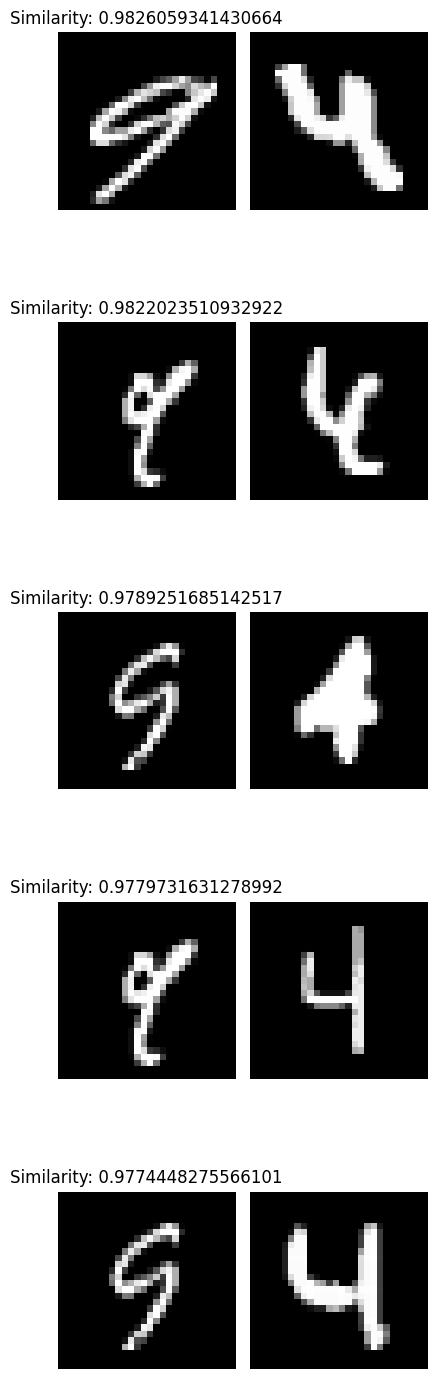

In [13]:
display_similar_items(9, 4, k=5)

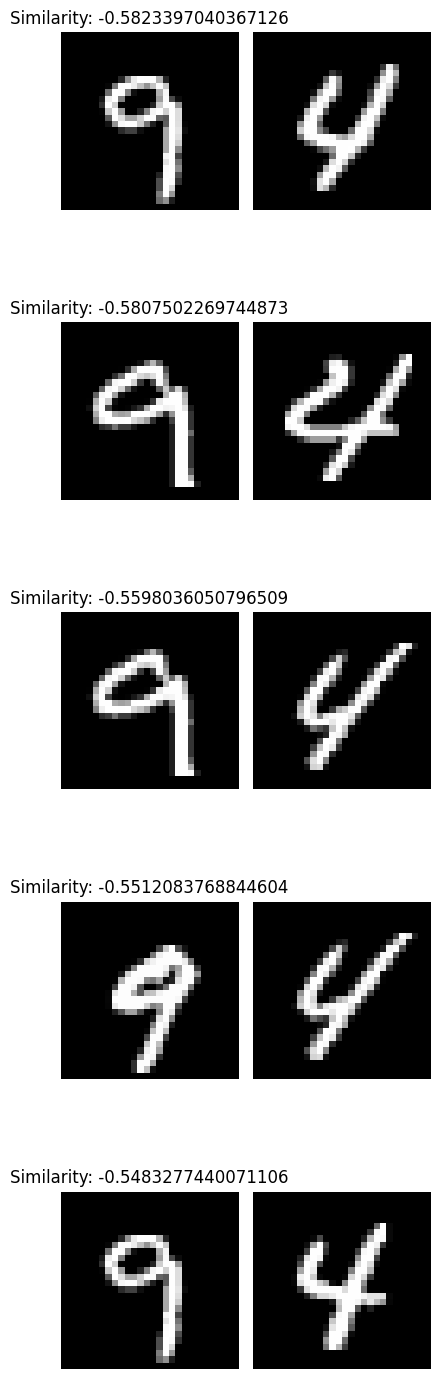

In [14]:
display_dissimilar_items(9, 4, k=5)

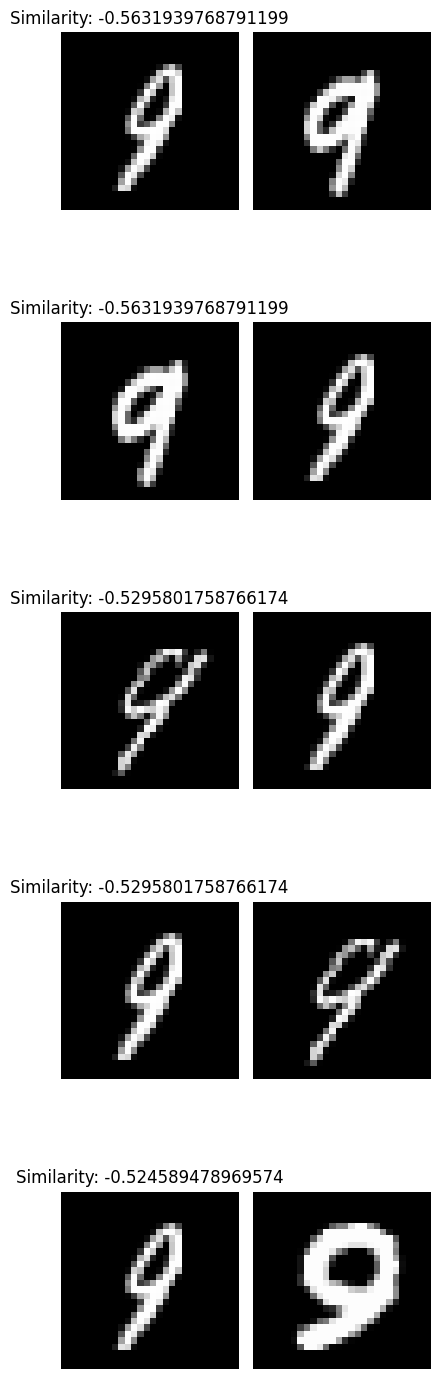

In [15]:
display_dissimilar_items(9, 9, k=5)